### Load packages, blob storage path, and required packages and our custom functions from [helper_functions](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1858507102381816/command/1858507102381817)

In [0]:
%run "./helper_functions"

In [0]:
# Load the custom cross validator available in the class folder
spark.sparkContext.addPyFile("dbfs:/custom_cv.py")
from custom_cv import CustomCrossValidator

In [0]:
# set-up path to blob storage
blob_container = "w261" # The name of your container created in https://portal.azure.com
storage_account = "bdougall" # The name of your Storage account created in https://portal.azure.com
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

# Phase Summary
## Executive Summary
In the final phase, we continued to develop and refine new time-based features based on our eda and a detailed analysis of missed predictions. We developed several novel time-based features which are further described in section 4 on feature engineering. In addition, we implemented an XGboost model.

We found that the time-based features we engineered were ranked by the model as the most important/useful for separating the classes. The weather features, on the other hand, were essentially not used by the model, despite common sense that weather has an impact on flight delays. A key conclusion is simply that continued development and refinement of these all of these features (both the time-based and weather features) combined with detailed analysis of missed predictions can still lead to significant improvements in the model. 

However, as of the time of writing, we can see on the leaderboard that we have the 3rd highest recall score (our priority metric), and the 3rd highest F1 score (indicating that our model is not too imbalanced). Our results relative to other groups suggest that we made a competitive model given the time limitations and learning curve involved.

## Phase 1
#### Explain data
Exploratory analysis was completed on three datasets - the airlines, the weather and the stations.

Airlines: core data on each flight including its outcome (delayed, cancelled, diverted)
Weather: data on weather observations over time at various weather stations
Stations:  data that can be used to link each weather station ID to an ICAO call number

In addition we downloaded a dataset which maps ICAO call numbers to IATA call numbers in order to match weather stations to origin and destination airports.

#### Define the outcome
Outcome defined as a binary variable:

<img src="files/shared_uploads/bdougall@berkeley.edu/outcome_variable.png" width="400"/>

Primary evaluation metric to use: Recall

Also use Precision, Accuracy, and F1  to ensure model is not imbalanced.

#### Ingest the CSV files and represent them efficiently
The primary data was provided in Parquet format. We ingested using a Sparksession, and represented in a Spark DataFrame.

Parquet benefits include "the ability to easily split across multiple files, compression, nested types, and many others" [6]. 

Overall, column oriented storage methods like Parquet generally provide faster read times, particularly for wide datasets with many columns, making them a preferred storage layout for analytical processing [7]. We tested differences in read and write-time for Avro, a row-based storage file format, and did not observe appreciable differences in file read and write times. For this reason, we chose to use Parquet file formats throughout our checkpoints.

#### Join the Datasets

Added the ICAO codes for each origin airport and each destination.

Added the weather station for each origin and destination airport.

<img src="files/shared_uploads/bdougall@berkeley.edu/joined_fields.png" width="400"/>

Added field for 2 hours before the departure time and another for 3 hours before the departure time (all in UTC time).

Join earliest weather observation within time window provided above.

#### Checkpoint the data

Checkpointed the data by writing the data to Parquet storage in our team's storage container in Azure.

#### Split the data train/validation/test

When working with time-series data, we want to ensure we train on past data and then test on future data. The "leakage" of future data into the training data set doesn't provide a realistic 
train/test environment, and in many cases might bias our results.

We plan to use the blocking time series approach to ensure we train on past data and test on future data.

## Phase 2
#### EDA On All Tables
In phase 2 we completed EDA on all tables. Key outcomes of our EDA included confirming the distribution of our response variable (80-20), and confirming which airports do not have weather stations.

We also noted that the full dataset included a file airlines_size_test.parquet/, which duplicated the other files, so we did not import it.

#### Join Tables and Generate the Dataset
In Phase 2, we completed the join process on the dataset. 

#### EDA on Joined Table
After joining our weather data and dropping rows without weather observations, we lost 424,987 rows

We retained 98.6% of the data, and the lost rows mirrored the 80-20 distribution of the response variable

#### Missing data & Non-numerical features

Our primary strategy for missing data has been to drop the rows, as noted above after completing initial data cleaning and the join we still retained 98.6% of the original number of flight observations.

Non-numerical features were one-hot encoded where applicable.

#### Initial list of features / feature engineering 
Initial features utilized included:


| Feature Name | Description |
|:----:|--------|
| HOUR | The hour in local time of the flight's scheduled departure |
| wind_obs_type_origin | type of the most recent origin wind observation 3hrs. before to 2hrs. before scheduled departure |
| wind_obs_type_destination | type of the most recent destination wind observation 3hrs. before to 2hrs. before scheduled departure |
| wind_obs_speed_origin | m/sec speed rate of the most recent origin wind observation 3hrs. before to 2hrs. before scheduled departure |
| wind_obs_speed_destination | m/sec speed rate of the most recent destination wind observation 3hrs. before to 2hrs. before scheduled departure |
| Other Weather Features Etc. | Other weather features such as Ceil_Height, Visibility Etc. |

For further info on final features used see section 4 on Pre-Processing / Feature Engineering

#### Baseline Modeling 

We performed initial baseline modeling using a logistic regression model and a decision tree model

For further info see section 5 on algorithm exploration / theory.

## Phase 3
#### Creation of Time-Based Features

Based on our EDA, we believe that one of the most important ways to improve model performance is through tracking the status of a given plane via its Tail_Num over time, and creating features that help our model to understand the relationship between the status of the plane on previous flights and its departure on upcoming flights. For example, a plane that departs late on its previous flight may be at risk of departing late on its next flight depending on the delay and the required turn-around time.

In phase 3 we created several time-based features to help capture this info including:

| Feature Name | Description |
|:----:|--------|
| origin_perc_24to2 | Rolling percentage of flights delayed leaving an origin between 24 hrs. to 2 hrs. before the current flight's scheduled departure |
| last_flight_delayed | Whether or not the last flight of the same tail number experienced a delay of 15+ min/diversion/cancellation |
| amount_last_delay | Amount of delay of the last flight of the same tail number |

For a complete list of time-based features see section 4 below on feature engineering.

During the creation of our time-based features we dropped an additional 70,504 rows for flights with no prior information about the prior flight of the plane’s tail number. These primarily represent cancelled flights which were likely cancelled well in advance of the 2 hour cutoff as no plane was ever assigned.

#### Baseline model

Baseline models tested included Logistic regression and Decision tree models. For additional info see section 5 on algorithm exploration.

#### Fine-tuned model 
Overall, when considering our problem we felt decision tree models, with their ability to capture non-linear problem spaces, would be better suited for this problem than linear models such as logistic regression. This hypothesis was bolstered by the performance of our baseline models.

When fine tuning our model, we proceeded forward with decision tree type models and tested a Random Forest model. We found improved performance with the Random Forest, and then fine-tuned the hyperparameters on this model using grid search.

#### Gap analysis
At the end of phase three our model was performing poorly, especially compared to the top score on the leaderboard which boasted an impressive precision of 92.8% and recall of 66.5%. To help close the gap we did a deep dive on areas where our model was mis-classifying the outcome, and determined that we should review our time-based features and engineer new ones. In addition, we tried implementing an XGBoost model, and found it improved performance.

## Phase 4
#### Final model
In our final stages we also tried using an XGBoost model and again found improved performance. For additional info see section 6 on implementation.

#### Hyperparameter tuning
Unfortunately when using the XGboost model we had difficulty with hyperparameter tuning via grid search due to scalability issues (see section 6 for additional details). However the model still outperformed the fine-tuned random forest model.

#### Feature engineering
Throughout phase 3 and phase 4 we continued to engineer and refine time-based features such as:

| Feature Name | Description |
|:----:|--------|
| arrival_time_2_next_flight | The amount of time between the actual arrival time of the prior flight and the current flight's scheduled departure |
| last_flight_late_arrival | Whether or not the prior flight for the same tail number experienced a late arrival |

We found these features to be the most signicant in improving our model. For additional information see section 4 on feature engineering, and section 7 on conclusions.

### Novel directions
The primary novel direction we pursued involved the time-based features. In our EDA and deep-dive on misclassified outcomes, we identified that many outcomes were highly predicible to the human eye based on simply following the status of a given plane. For example, a plane might be cancelled going from IAD to LGA, and in that case it is easy for a human to predict that the plane's next flight from LGA to another airport will also be cancelled, but a machine-learning model cannot necessarily capture this info. We developed numerous time-based features to help capture this sort of information, and found that they significantly improved our performance.

In addition, we also tried to address the class imbalance of our outcome variable by implementing SMOTE.

### Gap analysis and future directions
Our final model achieved the following results:

| Metric | Train | Test |
|:----:|--------|--------|
| F1-score | 0.753 | 0.600 |
| Recall | 0.699 | 0.689 |
| Precision | 0.817 | 0.532 |
| Accuracy | 77.5% | 81.6% |

Examining the results of other groups on the leaderboard at the time of writing, we can see that we had the 3th highest F1 score, the 3rd highest recall score, and the 3rd highest accuracy (there were not enough groups with precision as a metric to compare performance). This is an encouraging result, especially when considering that none of the groups that outperformed our model on specific metrics were able to outperform our model on every metric. Our results relative to other groups suggest that we made a competitive model which was able to predict both classes well, despite our focus on metrics that would translate to a better customer experience.

For further improvements, some future directions we would explore include additional feature engineering (perhaps including holidays and other time-based features), new algorithms for addressing the class imbalance, and potentially reducing the size of the dataset to make room for more computational complexity in our XGboost model.

# Question Formulation
##### Introduce data sets and contexts 
Flight delay imposes significant cost on passengers and airlines. According to the _Cost of Delay Estimates_[1] published by FAA (Federal Aviation Association), the total costs of delay in the U.S. in 2016, 2017, 2018, 2019 were $23.7 billion, $26.6 billion, $30.2 billion and $33.0 billion respectively, of which passengers bear more than half. Passenger costs result from time lost due to schedule buffers, delayed flights, flight cancellations, and missed connections. In addition, so-called "voluntary departure time adjustments", which refers to the adjustments passengers make to take the possibility of arrival delays into consideration.

Serving as data scientists in a customer relationship department within an airline company, we are dedicated to improving customer satisfaction by providing more accurate flight delay predictions based on three data sets - flights table and weather table with a history of 2015 to 2019 data, as well as the station table that connects the flights and weather by weather stations. So we casted ourselves into a passenger-oriented perspective. The objective of this project is to predict departure delay or no delay, where a delay is defined as 15-minute delay with respect to the planned time of departure. Considering the cancelled and diverted flights are part of the passenger burden, we defined the target as a binary variable, with a value of 0 indicating no delay, and a value of 1 indicating a delay of 15 minutes or greater, diverted and cancelled flight. 

##### Articulate question and takes limitations of the data and/or algorithm into account
The question we are facing is a binary classification question - will the flight be delayed/cancelled/diverted, or not. Logistic Regression, Decision Tree, Random Forest, and XGBoost were employed in our analysis. 

Logistic regression uses a linear model with a sigmoid function to return the probability of a label. It is easy to interpret, however, it is best suited to modeling linear relationships, and in the case of our dataset, we felt this might not be the best fit. We turned to decision tree models for further analysis, and had some success, however significant feature engineering work was needed to help the model capture patterns in the data. For example, it is difficult to make the model understand that when a plane is delayed in one location, and it is scheduled to arrive to another location and then turn around quickly for another flight, the exact delay time and turn around time can allow a human observer to make an accurate delay prediction.

In the end, although we moved in the right direction, additional feature engineering work is likely needed to improve the model. Further info on algorithms and feature engineering is provided in sections 4, 5, and 6 below.

##### Discuss evaluation metrics
Taking on the same passenger-oriented view that we used to define our target variable, we can reason that the best way to keep passengers satisfied will be to focus on optimizing for delay predictions, rather than trying to perfectly balance the accuracy of our predictions for on-time and delayed flights. This is the case because a passenger that is correctly notified of an upcoming delay, or one that sees their flight arrive on-time despite a predicted delay will likely be more satisfied than a passenger who expects their flight to arrive on time, only to find that it is delayed.

Using this framework, we can reason that correctly identifying true positives is more important than correctly identifying true negatives. Therefore, we plan to focus on optimizing for the Recall measure, which calculates the fraction of true positives identified by the model. Other metrics such as precision and F1 will be utilized to ensure our model is not highly imbalanced. The formula for recall is as follows (where TP is the count of true positives identified by the model and FN is the count of false negatives identified by the model):
$$Recall = \dfrac{TP}{TP + FN}$$

##### Baselines, state-of-the-art literature
Several papers present optimization models in this area. For example, the older Regression method[2] has been used to compute delay propagation. For this model, the destination delay is highly dependent on arrival flights and the effective factors include; day, time, airport capacity and some factors are related to passenger loads. In addition, as the problem neglects the weather conditions, this model shows inefficiency in the USA but it is suitable for Europe. Chakrabarty N (2019) analyzed flight information of U.S domestic flights operated by American Airlines[3], covering top 5 busiest airports of the US and predicting possible arrival delays of the flight using Data Mining and Machine Learning Approaches. Due to the imbalanced data Over-Sampling technique, Randomized SMOTE was applied for Data Balancing. The Gradient Boosting Classifier Model was deployed by training and then Grid Search on Gradient Boosting Classifier Model on flight data, causing hyper-parameter tuned and achieving a maximum accuracy of 85.73%. However, this model only studied American Airlines flights data, therefore lacks larger scale data at other flights level and longer time periods.

# EDA

### Key EDA Task 1: understanding distribution of response variable

We confirmed the distribution of our response variable is 80-20. This is critical because simply guessing the majority class will return 80% accuracy. Re-balancing of the classes may help to improve model results for recall.

+-------+--------+
OUTCOME| count|
+-------+--------+
 0|25519847|
 1| 6226994|
+-------+--------+

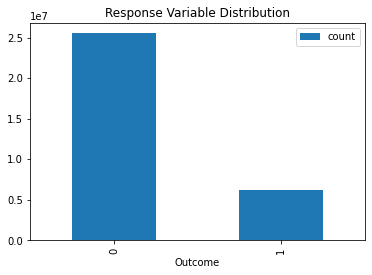

In [0]:
check_outcome = F.udf(check_outcome)
df_airlines = spark.read.parquet("/mnt/mids-w261/datasets_final_project/parquet_airlines_data/20*")
df_airlines = df_airlines.withColumn("OUTCOME",check_outcome('DEP_DEL15','CANCELLED','DIVERTED'))

def view_outcome(df):
    df.groupby('OUTCOME').count().toPandas().plot(kind='bar',title='Response Variable Distribution',xlabel='Outcome')
    df.groupby('OUTCOME').count().sort("OUTCOME","count").show()

view_outcome(df_airlines)

### Key EDA task 2: linking df_weather to df_stations to df_airlines

We confirmed the stations data provides a clear mapping of station_id to ICAO call (whenever distance to neighbor = 0). 

Our next step was to download a mapping of ICAO call to IATA call, allowing us to link station_id to ICAO call to the IATA call used for the origin and dest in the airlines DF.

<img src="files/shared_uploads/bdougall@berkeley.edu/joined_fields.png" width="400"/>

In [0]:
df_stations = spark.read.parquet("/mnt/mids-w261/datasets_final_project/stations_data/*")
display(df_stations.select('station_id','distance_to_neighbor','neighbor_call').filter(col('distance_to_neighbor')==0).limit(10))

station_id,distance_to_neighbor,neighbor_call
69002093218,0.0,KHGT
69007093217,0.0,KOAR
69014093101,0.0,KNZJ
70027127506,0.0,KPBA
70045027512,0.0,LNI
70063027403,0.0,POLI
70063526465,0.0,PAGB
70063627405,0.0,PAUD
70104626418,0.0,PACE
70119526625,0.0,PASH


Every unique station in the stations_df is represented by an entry with a distance_to_neighbor of 0, meaning its “neighbor” is simply the station itself.

In [0]:
def stations_check(df_stations):
    unique_stations_total = df_stations.select('station_id').distinct().count() 
    unique_stations_total_equal_zero = df_stations.select('station_id').filter(col('distance_to_neighbor')==0).distinct().count()
    print(f"Total number of unique stations in df_stations: {unique_stations_total}\nNumber of unique stations in df_stations where distance to neighbor equals zero: {unique_stations_total_equal_zero}")
          
stations_check(df_stations)

Total number of unique stations in df_stations: 2237
Number of unique stations in df_stations where distance to neighbor equals zero: 2237

### Key EDA task 3: understanding main sources of delays

We see that late aircraft delay is the largest source of delay. This highlights the importance of the time-based features described further in section 4 on feature engineering. The best predictor of delay will be to trace the status of an airplane identified by its unique tail_number in order to see what has been happening on its prior flights.

Out[56]:

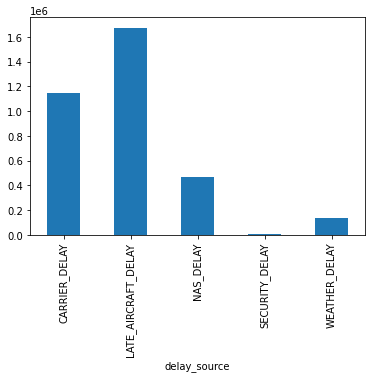

<AxesSubplot:xlabel='delay_source'>

In [0]:
def greatest_delay_source(df):
    
    delayed_flights = df.filter("YEAR<2019")\
                        .filter(col('DEP_DEL15') == '1.0')

    cond = "F.when" + ".when".join(["(F.col('" + c + "') == F.col('max_value'), F.lit('" + c + "'))" for c in delayed_flights.columns[56:61]])
    delayed_flights = delayed_flights.withColumn("max_value", F.greatest(delayed_flights.CARRIER_DELAY, delayed_flights.WEATHER_DELAY, delayed_flights.NAS_DELAY, delayed_flights.SECURITY_DELAY, delayed_flights.LATE_AIRCRAFT_DELAY)).withColumn("GREATEST_DELAY_SOURCE", eval(cond))

    delay_source = [x.GREATEST_DELAY_SOURCE for x in delayed_flights.select('GREATEST_DELAY_SOURCE').collect()]
    df_delayed = pd.DataFrame({'delay_source': delay_source})
    return df_delayed.groupby('delay_source').size().plot(kind='bar')

greatest_delay_source(df_airlines)

### Key EDA task 4: understanding the importance of time-based features

Looking visually at specific tail numbers sorted by UTC departure time, we can see what looks like strong autocorrelation for the outcome over time, with the outcome at lag 1, 2, etc. being a strong indicator of the outcome. This auto-correlation can be quantified with an ACF and PACF chart show below. Essentialy bad outcomes come in waves, as delays and cancellations lead to more delays and cancellations.

Overall, this EDA led us to believe the the key to improving model performance is through feature engineering to make the below time-based data more "machine readable". For example, any person can tell you that if a plane is delayed 60 mins going from IAD to LGA, and that same plane was expected to turn around from LGA and depart 60 mins later on its subsequent flight, then the subsequent flight will also be delayed.  However the key question is how to help a machine learning model understand this.

<img src="files/shared_uploads/bdougall@berkeley.edu/tail_num_trace.png" width="600"/>

TAIL_NUM,utc_scheduled_departure,DEP_DELAY,CANCELLED,OUTCOME
N832AS,2015-01-22T00:12:00.000+0000,-7.0,0.0,0
N832AS,2015-01-22T02:57:00.000+0000,7.0,0.0,0
N832AS,2015-01-22T10:55:00.000+0000,-6.0,0.0,0
N832AS,2015-01-22T13:16:00.000+0000,-6.0,0.0,0
N832AS,2015-01-22T15:15:00.000+0000,-3.0,0.0,0
N832AS,2015-01-24T13:37:00.000+0000,123.0,0.0,1
N832AS,2015-01-24T15:11:00.000+0000,104.0,0.0,1
N832AS,2015-01-25T13:37:00.000+0000,98.0,0.0,1
N832AS,2015-01-25T15:11:00.000+0000,77.0,0.0,1
N832AS,2015-01-26T17:31:00.000+0000,75.0,0.0,1


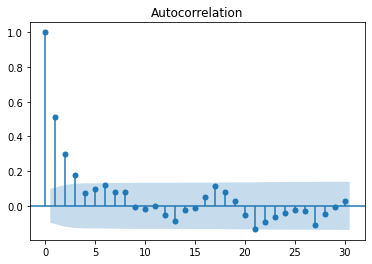

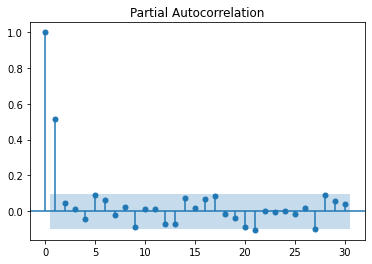

In [0]:
dt_transformed_table = spark.read.parquet(f"{blob_url}/dt_transformed_table")
def trace_tail(df):
    df = df.sort(col('TAIL_NUM'),col('utc_scheduled_departure').asc())
    display(dt_transformed_table.select('TAIL_NUM','utc_scheduled_departure','DEP_DELAY','CANCELLED','OUTCOME').filter((col('TAIL_NUM')=='N832AS') & (col('utc_scheduled_departure').between('2015-01-22','2015-01-29'))))
    ts_df = df.select('OUTCOME').filter(col('TAIL_NUM')=='N832AS').toPandas()
    plot_acf(ts_df['OUTCOME'], lags=30)
    plot_pacf(ts_df['OUTCOME'], lags=30)

trace_tail(dt_transformed_table)

# Preprocessing and Feature Engineering

<img src="files/shared_uploads/bdougall@berkeley.edu/Fig_1_reduced_whitespace.png" width="400"/>

##### Column Explanation
In order to join our flights table to our weather observations table, we needed to find the closest weather station to each origin and destination airport. However, the original flights and weather tables did not possess common fields for the join (the flights table does not contain weather station IDS and has dates and times in local time; weather does not contain airport codes and has UTC timestamps). We observed that the stations table does contain the distances of weather stations for each airport, which can be used to join flights to weather. However, the stations table contained ICAO airport codes rather than the IATA airport codes in flights. In addition, the stations table required filtering, as it originally contained multiple rows for each airport (each of these multiple rows represented a weather station and its distance from the airport). 

Our first round of feature engineering added the following features to flights, to prepare this table to be joined to both stations and weather. The fields `origin_ICAO` and `destination_ICAO` were dropped after the join with stations, while `origin_local_timezone` was dropped after creating the UTC timestamp fields. Code for this processing is shown below in `added_airline_features`; helper functions utilized by `add_airline_features` are imported from [helper_functions](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1858507102381816/command/1858507102381817).

| Feature Name | Description | Purpose | 
|:----:|--------|--------|
| origin_ICAO | ICAO code of the origin airport | join with stations |
| destination_ICAO | ICAO code of the destination airport | join with stations |
| origin_local_timezone | local timezone of the origin airport | create UTC timestamp |
| utc_scheduled_departure | the UTC timestamp of the flight's scheduled departure | creation of other time fields |
| utc_2hrs_before | the UTC timestamp for the cutoff 2 hrs. before the flight's scheduled departure | join with weather, creation of other time fields |
| utc_3hrs_before | the UTC timestamp for the cutoff 3hrs. before the flight's schedulede departure | join with weather |

Next, we selected the fields from weather that were of interest in our model, based upon our reading of the features guide for this table: `WND`, `CIG`, `VIS`, `TMP`, and `DEW`. As these columns contained concatenated features, we split the features into their own columns within `flights_weather_join`. Our join and checkpoint of the full dataset was completed in 5.67 hours, however, this join had included duplicate records, as we completed the join prior to discovering that the airlines test file contained duplicates of flights captured elsewhere (we have since refactored our code to avoid importing these observations). Post-join of the flights and weather tables, we had added the following additional features to the flights table. For these fields, we chose to use the window of time 3 hrs. to 2hrs. before the flight's scheduled departure to use the most recent weather conditions that were allowed to impact prediction of flight status.

| Feature Name | Description |
|:----:|--------|
| wind_obs_type_origin | type of the most recent origin wind observation 3hrs. before to 2hrs. before scheduled departure |
| wind_obs_type_destination | type of the most recent destination wind observation 3hrs. before to 2hrs. before scheduled departure |
| wind_obs_speed_origin | m/sec speed rate of the most recent origin wind observation 3hrs. before to 2hrs. before scheduled departure |
| wind_obs_speed_destination | m/sec speed rate of the most recent destination wind observation 3hrs. before to 2hrs. before scheduled departure |
| ceil_height_origin | the most recent origin ceiling height measurement 3hrs. before to 2hrs. before scheduled departure |
| ceil_height_destination | the most recent destination ceiling height measurement 3hrs. before to 2hrs. before scheduled departure |
| vis_dist_origin | the most recent origin visible distance measurement 3hrs. before to 2hrs. before scheduled departure |
| vis_dist_destination | the most recent destination visible distance measurement 3hrs. before to 2hrs. before scheduled departure |
| air_temp_origin | the most recent origin air temperature measurement 3hrs. before to 2hrs. before scheduled departure |
| air_temp_destination | the most recent destination air temperature measurement 3hrs. before to 2hrs. before scheduled departure |
| dew_point_temp_origin | the most recent origin dew point temperature measurement 3hrs. before to 2hrs. before scheduled departure |
| dew_point_temp_destination | the most recent destination dew point temperature measurement 3hrs. before to 2hrs. before scheduled departure |

Lastly, post-join of flights and weather, we created additional time features to help model flight outcome propogation through the network. The following features are created in `dt_table`.

| Feature Name | Description |
|:----:|--------|
| HOUR | The hour in local time of the flight's scheduled departure |
| OUTCOME | Whether or not the current flight experienced a delay of 15+ min/diversion/cancellation |
| rolling_perc_delayed  | Rolling percentage of flights delayed between an origin and destination from the beginning of time to 2 hrs. before the current flight's scheduled departure |
| origin_dest_perc_24to2 | Rolling percentage of flights delayed between an origin and a destination from 24 hrs. to 2 hrs. before the current flight's scheduled departure |
| origin_perc_24to2 | Rolling percentage of flights delayed leaving an origin between 24 hrs. to 2 hrs. before the current flight's scheduled departure |
| last_flight_delayed | Whether or not the last flight of the same tail number experienced a delay of 15+ min/diversion/cancellation |
| amount_last_delay | Amount of delay of the last flight of the same tail number |
| two_ago_delayed | Whether or not the tail number experienced delay 15+ min/diversion/cancellation 2 flights ago |
| three_ago_delayed | Whether or not the tail number experienced delay 15+ min/diversion/cancellation 3 flights ago |
| arrival_time_2_next_flight | The amount of time between the actual arrival time of the prior flight and the current flight's scheduled departure |
| last_flight_late_arrival | Whether or not the prior flight for the same tail number experienced a late arrival |
| two_ago_late_arrival | Whether or not the tail number experienced a late arrival 2 flights ago |
| three_ago_late_arrival | Whether or not the tail number experienced a late arrival 3 flights ago |

##### Missing Value Treatment

There are several areas where we handled missing values in our tables, which are noted below, as well as the rationale behind our approach.

1) Weather: 
    - We dropped observations with missing value indicators (e.g. wind speeds of 9999), since we found that fewer than 1% of observations had missing values in our selected fields.
2) During the airlines join to the ICAO/IATA map, airlines join to stations, and airlines join to weather
    - We performed inner joins to only retain flight observations that had ICAO codes, a closest origin and closest destination weather station, and origin and destination weather observations within our allowed time window. We chose to use inner joins since we were interested in the impact of origin and destination weather conditions near the scheduled departure time upon flight outcomes and in order to create a consistent time window for weather observations used in our predictive model.
3) During additional processing of the joined table
    - Post-join, we had discovered the existence of 70,504 records with null tail number values (corresponding to some of the cancelled flights). Since we wanted to trace flights by tail number to follow propogation of delays/diverted flights/cancellations, we chose to drop these records to avoid errors in our lag features (windowing over tail number will count all the nulls as the same tail number, even though these flights include multiple airlines).

##### Feature distributions and Transformations

After conducting our joins and creating additional features, we selected all years before 2018 (since 2019 is our hold-out test set and we are using 2018 for validation), and explored the feature distributions ([explore_joined](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/3816960191355881/command/3816960191357685)). In this analysis, we observed that some features are discrete (`YEAR`, `MONTH`, `DAY_OF_WEEK`, `HOUR`), while most are continuous. The distribution of most of our numeric features is skewed to varying degrees, save for `rolling_perc_delayed`, which appears approximately normal. The distribution of features varies widely in scale, and there is a high degree of correlation between some features - e.g. distance and scheduled elapsed time, dew point temperature and air temperature, and hour and air temperature. These findings suggest that additional transformations are likely for our logistic regression approach (scaling and regularization). However, a tree model, which can model non-linear data, is able to handle colinearity and differences in scale and does not require scaling, indicating that we needed to create two different pipelines - 1 for a logistic regression model and another for our tree-based models.

In [0]:
def load_data():
    """Loads the full flights, stations, and weather tables"""
    
    # Load the flights data, but drop duplicates
    flights = spark.read.parquet("/mnt/mids-w261/datasets_final_project/parquet_airlines_data/20*")
    
    # Load the stations data, only keeping rows where the distance between the airport and weather station is 0
    df_stations = spark.read.parquet("/mnt/mids-w261/datasets_final_project/stations_data/*")
    
    # Load the weather data and select only the U.S. weather observations
    df_weather = spark.read.parquet("/mnt/mids-w261/datasets_final_project/weather_data/*")

    return flights, df_stations, df_weather

In [0]:
def add_airline_features(stations, airlines):
    """A wrapper function that creates the cutoff time window features and adds the closest weather station ids for each airport"""
    
    # Create a Spark dataframe of the airport codes, latitudes, and longitudes
    url = 'https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat'
    spark.sparkContext.addFile(url)

    # Rename the file
    filename = SparkFiles.get(url.split("/")[-1])
    env_var = filename.split('.')[0]
    os.environ[env_var] = filename

    # Define the schema for the airport latitude and longitude file
    schema = StructType([
        StructField("index_num", FloatType(), True),
        StructField("airport_name", StringType(), True),
        StructField("city", StringType(), True),
        StructField("country", StringType(), True),
        StructField("IATA", StringType(), True),
        StructField("ICAO", StringType(), True),
        StructField("latitude", FloatType(), True),
        StructField("longitude", FloatType(), True),
        StructField("altitude", FloatType(), True),
        StructField("utc_offset", FloatType(), True),
        StructField("dst", StringType(), True),
        StructField("tz_database_timezone", StringType(), True),
        StructField("type", StringType(), True),
        StructField("source", StringType(), True)])

    # Create the Spark dataframe
    airline_lat_long = spark.read.csv("/airports.dat", header=True, schema=schema).toPandas()

    # Filter the Spark dataframe to only U.S. airports
    us_airport_locs = spark.createDataFrame(airline_lat_long[airline_lat_long.country == 'United States']).select('IATA', 'ICAO', 'latitude',
                                                                                                                  'longitude',
                                                                                                                  'tz_database_timezone')
  
    # Add the airport ICAO codes and timezones
    airlines_2 = add_airport_icao_coords(us_airport_locs, airlines)
    
    # Limit station observations to those with a distance of 0 from the airport
    stations = stations.withColumn('distance_to_neighbor', col('distance_to_neighbor').cast(IntegerType()))\
                          .filter(col('distance_to_neighbor') == 0)
    # Select only the desired fields for the join
    stations = stations.select('neighbor_call', 'station_id', 'distance_to_neighbor')
  
    # Add the closest weather station to each origin airport
    airlines_3 = nearest_origin_station(airlines_2, stations)
  
    # Add the weather station to each destination airport
    airlines_4 = nearest_destination_station(airlines_3, stations)
  
    # Add the cutoff window for features to be included in predicting flight delay
    airlines_f = add_cutoff_window(airlines_4)
    
    return airlines_f

In [0]:
def flights_weather_join(airlines_w_stations, df_weather):
    
    # Select only the desired weather fields and observations
    df_weather = parse_concatenated_fields(df_weather)
    
    # Select the features from the flights table that will be used to find matching weather observations
    airlines_origin_select = airlines_w_stations.select('origin_weather_station', 'utc_3hrs_before', 'utc_2hrs_before')

    # Set the join conditions
    origin_join_condition = [(df_weather.STATION == airlines_origin_select.origin_weather_station) & (df_weather.DATE.between(airlines_origin_select.utc_3hrs_before, airlines_origin_select.utc_2hrs_before))]

    # Perform an inner join of the weather observations to these select features
    weather_origin_obs = df_weather.join(airlines_origin_select, origin_join_condition, 'inner')
    
    # Create a group to partition by - this will be the STATION, the utc 3hr time, and the utc 2 hr time
    weather_origin_obs = weather_origin_obs.withColumn('groups', concat(col('STATION'), lit(','), 
                                                                    col('utc_3hrs_before'), lit(','), col('utc_2hrs_before')))
    # creating a window partition to select the most recent weather observation for each window
    w = Window.partitionBy('groups').orderBy(desc('DATE'))
    weather_origin_obs = weather_origin_obs.withColumn('row_number', row_number().over(w))

    # Filter to keep only the latest observation for each group and drop unnecessary columns
    weather_origin_obs = weather_origin_obs.filter(weather_origin_obs.row_number == 1).drop('row_number', 'LATITUDE', 'LONGITUDE', 'origin_weather_station', 
                                                                                            'groups')

    # Add the origin suffix for all weather columns
    select_list = [col(col_name).alias(col_name + "_origin")  for col_name in weather_origin_obs.columns]

    # Add the origin suffix to all weather columns
    weather_origin_obs = weather_origin_obs.select(*select_list)
    
    # Use an inner join to join the weather at origin to the airlines data
    # Set the join conditions
    origin_join_condition_2 = [(weather_origin_obs.STATION_origin == airlines_w_stations.origin_weather_station) & 
                             (weather_origin_obs.utc_3hrs_before_origin == airlines_w_stations.utc_3hrs_before) & 
                             (weather_origin_obs.utc_2hrs_before_origin == airlines_w_stations.utc_2hrs_before)]

    # Use an inner join to drop flights without corresponding weather observations
    airlines_w_origin_weather = airlines_w_stations.join(weather_origin_obs, origin_join_condition_2, 'inner')

    # Drop unnecessary fields from airlines_w_origin_weather
    airlines_w_origin_weather = airlines_w_origin_weather.drop('origin_latitude', 'origin_longitude', 'origin_local_timezone', 
                                                              'destination_latitude', 'destination_longitude', 'destination_local_timezone', 
                                                              'STATION_origin', 'utc_3hrs_before_origin', 'utc_2hrs_before_origin')

    # Select the features from the flights table that will be used to find matching weather observations
    airlines_dest_select = airlines_w_origin_weather.select('destination_weather_station', 'utc_3hrs_before', 'utc_2hrs_before')

    # Set the join conditions
    dest_join_condition = [(df_weather.STATION == airlines_dest_select.destination_weather_station) &
        (df_weather.DATE.between(airlines_dest_select.utc_3hrs_before, airlines_dest_select.utc_2hrs_before))]

    # Perform an inner join of the weather observations to these select features
    weather_dest_obs = df_weather.join(airlines_dest_select, dest_join_condition, 'inner')

    # Create a group to partition by - this will be the STATION, the utc 3hr time, and the utc 2 hr time
    weather_dest_obs = weather_dest_obs.withColumn('groups', concat(col('STATION'), lit(','), 
                                                                        col('utc_3hrs_before'), lit(','), col('utc_2hrs_before')))
    # creating a window partition to select the most recent weather observation for each window
    w = Window.partitionBy('groups').orderBy(desc('DATE'))
    weather_dest_obs = weather_dest_obs.withColumn('row_number', row_number().over(w))

    # Filter to keep only the latest observation for each group and drop unnecessary columns
    weather_dest_obs = weather_dest_obs.filter(weather_dest_obs.row_number == 1).drop('row_number', 'LATITUDE', 'LONGITUDE', 'destination_weather_station', 
                                                                                            'groups')
    
    # Add the origin suffix for all weather columns
    dest_select_list = [col(col_name).alias(col_name + "_destination")  for col_name in weather_dest_obs.columns]

    # Add the origin suffix to all weather columns
    weather_dest_obs = weather_dest_obs.select(*dest_select_list)

    dest_join_condition_2 = [(weather_dest_obs.STATION_destination == airlines_w_origin_weather.destination_weather_station) & 
                             (weather_dest_obs.utc_3hrs_before_destination == airlines_w_origin_weather.utc_3hrs_before) & 
                             (weather_dest_obs.utc_2hrs_before_destination == airlines_w_origin_weather.utc_2hrs_before)]

    # Use an inner join to drop flights without corresponding weather observations
    airlines_w_weather = airlines_w_origin_weather.join(weather_dest_obs, dest_join_condition_2, 'inner')

    # Drop unnecessary fields
    airlines_w_weather = airlines_w_weather.drop('destination_call', 'STATION_destination', 'utc_3hrs_before_destination', 
                                                'utc_2hrs_before_destination')

    return airlines_w_weather

In [0]:
def dt_table(df):
    """Creates the dataset for decision tree training/testing"""
    
    def check_outcome(dep_del15, cancelled, diverted):
        """Bin cancelled, diverted, and delayed flights with a delay of 15+ minutes"""
        x = 0
        if dep_del15 == 1 or cancelled == 1 or diverted == 1:
            x = 1
        return x

    # Drop duplicates where the entire row is duplicated
    df = df.dropDuplicates()
    
    # Drop rows where the tail number is null
    df = df.na.drop(subset=["TAIL_NUM"]) 
    
    # Keep only columns of interest
    df = df.select('YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER',
                   'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CANCELLED', 'DIVERTED',
                   'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 
                   'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK','CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 
                   'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 
                   'DISTANCE', 'utc_scheduled_departure', 'utc_2hrs_before', 'utc_3hrs_before',
                   'wind_obs_type_origin', 'wind_obs_speed_origin', 'ceil_height_origin', 
                   'vis_dist_origin', 'air_temp_origin', 'dew_pt_temp_origin',
                   'wind_obs_type_destination', 'wind_obs_speed_destination', 'ceil_height_destination',
                   'vis_dist_destination', 'air_temp_destination','dew_pt_temp_destination')
    
    # Create a udf to extract the hour of the local time scheduled departure and use this function to make a new column hour field
    df = df.withColumn('scheduled_departure', F.to_timestamp(F.concat(df.FL_DATE, F.lpad(df.CRS_DEP_TIME, 4, '0')), 
                                                                                format='yyyy-MM-ddHHmm'))
    hour = F.udf(lambda x: x.hour, IntegerType())
    df = df.withColumn('HOUR', hour("scheduled_departure"))
    df = df.drop('scheduled_departure')
    
    # Create a udf to bin diverted and cancelled flights and those with a delay 15+ min
    check_outcome = F.udf(check_outcome)
    df = df.withColumn('OUTCOME',check_outcome('DEP_DEL15','CANCELLED','DIVERTED'))
    
    # Keep the original rolling percent delayed field (over all time)
    # Get the % of flights delayed by 15+ min, delayed, or diverted from an origin to a destination as a rolling percent
    origin_dest_window_1 = Window.partitionBy(['ORIGIN','DEST']).orderBy(col('utc_scheduled_departure').cast('long'))\
                               .rangeBetween(-sys.maxsize, (Window.currentRow - 7200))
    # Create a new column for the total number of flights delayed 15+ min/diverted/cance
    df = df.withColumn('rolling_sum', F.sum('OUTCOME').over(origin_dest_window_1))
    df = df.withColumn('rolling_perc_delayed', col('rolling_sum')/F.count(col('OUTCOME')).over(origin_dest_window_1)*100)
    df = df.drop('rolling_sum')
    
    # Get the % of flights delayed by 15+ min, delayed, or diverted from an origin to a destination as a rolling percent
    # over the last 24 hours before and up to 2 hours before the current flight
    origin_dest_window_2 = Window.partitionBy(['ORIGIN','DEST']).orderBy(col('utc_scheduled_departure').cast('long'))\
                               .rangeBetween((Window.currentRow - 86400), (Window.currentRow - 7200))
    
    # Create a new column for the total number of flights delayed 15+ min/diverted/cance
    df = df.withColumn('rolling_sum', F.sum('OUTCOME').over(origin_dest_window_2))
    df = df.withColumn('origin_dest_perc_24to2', col('rolling_sum')/F.count(col('OUTCOME')).over(origin_dest_window_2)*100)
    df = df.drop('rolling_sum')
    
    # Create a new column for the percent of flights delayed from the origin over the last 24 hours
    origin_window = Window.partitionBy(['ORIGIN']).orderBy(col('utc_scheduled_departure').cast('long'))\
                               .rangeBetween((Window.currentRow - 86400), (Window.currentRow - 7200))
    
    # Create a new column: % of origin flights delayed 15+ min/diverted/cancelled between 24 - 2 hours before the current flight's scheduled departure
    df = df.withColumn('rolling_origin_sum', F.sum('OUTCOME').over(origin_window))
    df = df.withColumn('origin_perc_24to2', col('rolling_origin_sum')/F.count(col('OUTCOME')).over(origin_window)*100)
    df = df.drop('rolling_origin_sum')
  
    # Create a new column for UTC actual departure, UTC scheduled arrival, and UTC actual arrival times
    df = df.withColumn('utc_actual_dep', (F.unix_timestamp(col('utc_scheduled_departure')) + col('DEP_DELAY')*60).cast('timestamp'))
    df = df.withColumn('utc_scheduled_arrival', (F.unix_timestamp(col('utc_scheduled_departure')) + col('CRS_ELAPSED_TIME')*60).cast('timestamp'))
    df = df.withColumn('utc_actual_arrival', (F.unix_timestamp(col('utc_actual_dep')) + col('ACTUAL_ELAPSED_TIME')*60).cast('timestamp'))
    
    # Create the window of the flight tail number's last scheduled and actual departure times
    scheduled_dep_window = Window.partitionBy('TAIL_NUM').orderBy('utc_scheduled_departure')
    
    # Create new columns, representing the last scheduled departure time and last actual departure time of a flight by tail number
    df = df.withColumn('last_flight_scheduled_dep', F.lag(col('utc_scheduled_departure'), 1, None).over(scheduled_dep_window))\
            .withColumn('last_flight_outcome', F.lag(col('OUTCOME'), 1, None).over(scheduled_dep_window))\
           .withColumn('last_delay_amount', F.lag(col('ARR_DELAY'), 1, None).over(scheduled_dep_window))\
           .withColumn('last_flight_actual_dep', F.lag(col('utc_actual_dep'), 1, None).over(scheduled_dep_window))
    
    # If the last flight's scheduled departure + 15 min is at least 2 hours before the current flight add the status of the last flight
    # otherwise, add an indicator for unknown
    df = df.withColumn('last_flight_delayed', 
                       when(((col('last_flight_scheduled_dep') + expr('INTERVAL + 15 MINUTES')) > col('utc_2hrs_before')), -1)\
                       .when(((col('last_flight_scheduled_dep') + expr('INTERVAL + 15 MINUTES')) <= col('utc_2hrs_before')), col('last_flight_outcome'))\
                       .otherwise(-1))
    
    # Quantify the delay of the prior flight, if its actual departure was 2 hours or more before the scheduled departure of the next flight
    df = df.withColumn('amount_last_delay', when(col('last_flight_actual_dep') <= col('utc_2hrs_before'),
                                                 col('last_delay_amount')).otherwise(-9999))\
           .drop('last_flight_scheduled_dep', 'last_flight_outcome', 'last_delay_amount', 'last_flight_actual_dep')
    
    # Create new columns, representing the scheduled departure time and actual departure of the same tail number two flights ago
    df = df.withColumn('twoago_scheduled_dep', F.lag(col('utc_scheduled_departure'), 2, None).over(scheduled_dep_window))\
             .withColumn('twoago_outcome', F.lag(col('OUTCOME'), 2, None).over(scheduled_dep_window))
    
    # If the same tail number 2 flights ago is scheduled to depart at least 2 hours + 15 min before the current flight add its status
    # Otherwise, mark it as unknown
    df = df.withColumn('two_ago_delayed', 
                       when(((col('twoago_scheduled_dep') + expr('INTERVAL + 15 MINUTES')) > col('utc_2hrs_before')), -1)\
                       .when(((col('twoago_scheduled_dep') + expr('INTERVAL + 15 MINUTES')) <= col('utc_2hrs_before')), col('twoago_outcome'))\
                       .otherwise(-1)).drop('twoago_scheduled_dep', 'twoago_outcome')
    
    # Add a status of delayed if the flight with the same tail number 3 flights ago is scheduled to depart at least 2 hours before the current flight
    # and flight 3 flights ago is delayed 15+ min, diverted, or cancelled
    df = df.withColumn('threeago_scheduled_dep', F.lag(col('utc_scheduled_departure'), 3, None).over(scheduled_dep_window))\
             .withColumn('threeago_outcome', F.lag(col('OUTCOME'), 3, None).over(scheduled_dep_window))
    df = df.withColumn('three_ago_delayed', 
                       when(((col('threeago_scheduled_dep') + expr('INTERVAL + 15 MINUTES')) > col('utc_2hrs_before')), -1)\
                       .when(((col('threeago_scheduled_dep') + expr('INTERVAL + 15 MINUTES')) <= col('utc_2hrs_before')), col('threeago_outcome'))\
                       .otherwise(-1)).drop('threeago_scheduled_dep', 'threeago_outcome')
    
    # Create a new column for whether or not the prior flight experienced a late arrival
    df = df.withColumn('last_flight_scheduled_arrival', F.lag(col('utc_scheduled_arrival'), 1, None).over(scheduled_dep_window))\
           .withColumn('last_flight_actual_arrival', F.lag(col('utc_actual_arrival'), 1, None).over(scheduled_dep_window))
    
    # Add a new column to represent the difference in the scheduled arrival time of the previous flight
    # and the scheduled departure of the current flight (add an indicator if there were no previous flights for that tail number)
    df = df.withColumn('arrival_time_2_next_flight', 
                       when(col('last_flight_scheduled_arrival').isNotNull(), 
                            col('utc_scheduled_departure').cast("long") - col('last_flight_scheduled_arrival').cast("long"))\
                      .otherwise(-9999))
    
    # Add a field representing whether or not the last flight experienced a late arrival/no arrival (cancellations/diversions)
    df = df.withColumn('last_flight_late_arrival', when((col('last_flight_scheduled_arrival') <= col('utc_2hrs_before')) & 
                                                       (col('last_flight_actual_arrival') > col('last_flight_scheduled_arrival')), 1)
                                                   .when((col('last_flight_scheduled_arrival') <= col('utc_2hrs_before')) & 
                                                          (col('last_flight_actual_arrival').isNull()), 1)\
                                                   .when(col('last_flight_scheduled_arrival') > col('utc_2hrs_before'), -1).otherwise(0))
    df = df.drop('last_flight_scheduled_arrival', 'last_flight_actual_arrival')
    
    # Create a new column for whether or not the flight with the same tail number two flights ago had a late arrival
    df = df.withColumn('twoago_flight_scheduled_arrival', F.lag(col('utc_scheduled_arrival'), 2, None).over(scheduled_dep_window))\
           .withColumn('twoago_flight_actual_arrival', F.lag(col('utc_actual_arrival'), 2, None).over(scheduled_dep_window))
    df = df.withColumn('two_ago_late_arrival', when((col('twoago_flight_scheduled_arrival') <= col('utc_2hrs_before')) & 
                                                       (col('twoago_flight_actual_arrival') > col('twoago_flight_scheduled_arrival')), 1)
                                               .when((col('twoago_flight_scheduled_arrival') <= col('utc_2hrs_before')) & 
                                                          (col('twoago_flight_actual_arrival').isNull()), 1)\
                                               .when(col('twoago_flight_scheduled_arrival') > col('utc_2hrs_before'), -1)\
                                               .otherwise(0))
    df = df.drop('twoago_flight_scheduled_arrival', 'twoago_flight_actual_arrival')
    
    # Create a new column for whether or not the flight with the same tail number three flights ago had a late arrival
    df = df.withColumn('threeago_flight_scheduled_arrival', F.lag(col('utc_scheduled_arrival'), 3, None).over(scheduled_dep_window))\
           .withColumn('threeago_flight_actual_arrival', F.lag(col('utc_actual_arrival'), 3, None).over(scheduled_dep_window))
    df = df.withColumn('three_ago_late_arrival', when((col('threeago_flight_scheduled_arrival') <= col('utc_2hrs_before')) & 
                                                       (col('threeago_flight_actual_arrival') > col('threeago_flight_scheduled_arrival')), 1)
                                                 .when((col('threeago_flight_scheduled_arrival') <= col('utc_2hrs_before')) &
                                                       (col('threeago_flight_actual_arrival').isNull()), 1)\
                                                 .when(col('threeago_flight_scheduled_arrival') > col('utc_2hrs_before'), -1)\
                                                 .otherwise(0))
    df = df.drop('threeago_flight_scheduled_arrival', 'threeago_flight_actual_arrival')
                                                

    # Drop columns that are no longer needed
    drop_cols = ['DEP_TIME','DEP_TIME_BLK', 'DEP_DELAY','DEP_DELAY_NEW','DEP_DEL15','DEP_DELAY_GROUP',
                 'DAY_OF_MONTH','QUARTER','OP_CARRIER_FL_NUM','CRS_DEP_TIME','ARR_TIME','ACTUAL_ELAPSED_TIME',
                 'ELEVATION_origin','ELEVATION_destination','utc_actual_dep', 'utc_scheduled_arrival', 'utc_actual_arrival',
                 'utc_3hrs_before', 'CANCELLED', 'DIVERTED', 'ARR_DELAY']
    df = df.drop(*drop_cols)
    # Drop rows where there was no prior flight between an origin and a destination                 
    df = df.na.drop(subset=["rolling_perc_delayed"]) 
    
    # Fill in 0 in fields with missing values
    df = df.na.fill(0)                  
    
    # Cast the indicator fields to string type
    df = df.withColumn('last_flight_delayed', col('last_flight_delayed').cast(StringType()))\
           .withColumn('two_ago_delayed', col('two_ago_delayed').cast(StringType()))\
           .withColumn('three_ago_delayed', col('three_ago_delayed').cast(StringType()))\
           .withColumn('last_flight_late_arrival', col('last_flight_late_arrival').cast(StringType()))\
           .withColumn('two_ago_late_arrival', col('two_ago_late_arrival').cast(StringType()))\
           .withColumn('three_ago_late_arrival', col('three_ago_late_arrival').cast(StringType()))\
    
    return df

# Algorithm Theory

Throughout the four phases we performed numerous modeling attempts with different datasets, features, and methodologies in several notebooks. A final run of the baseline models using a selection of our most important final features is provided for reference here: [model_test](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/4070574710006909/command/1858507102376347).

####Logistic Regression

Given the binary nature of the response variable in this problem, we initially chose to explore a logistic regression model. In a logistic regression, model predictions are produced using a learned intercept a, and a learned vector of coefficients b through the following equation:

$$P = \dfrac{e^{(a+bX)}}{1 + e^{(a+bX)}}$$

(Where P is rounded to 0 or 1 to match the binary nature of the response variable and X is a numeric feature vector.)

However, this model could not account for more complex relationships between features. We quickly found that modeling a non-linear feature space exemplified below by a chain of IF statements would be more suited to this problem, particularly when looking at time-based features for a given plane. For example, IF a plane is delayed 60 mins, and IF it has 8 hours from arrival at the next airport until its next flight, then that delay likely has no impact on the subsquent flight. However, IF a plane is delayed 60 mins, and IF the plane is expected to turn around in 60 minutes, then the delay will certainly lead to a delay on the subsquent flight. Our subsequent algorithm choice was better suited to modeling these complex feature relationships within our problem space. 

####Decision Tree (Toy Example):

Our decision to primarily use decision tree type models, stemmed from their fundemental difference from regression type models, which is well described in An Introduction to Statistical Learning:

"Which model is better? It depends on the problem at hand. If the relationship between the features and the response is well approximated by a linear model as in (8.8), then an approach such as linear regression will likely work well, and will outperform a method such as a regression tree that does not exploit this linear structure. If instead there is a highly non-linear and complex relationship between the features and the response as indicated by model (8.9), then decision trees may outperform classical approaches."[5]

Our initial hypothesis was bolstered when we found much better performance using a decision tree model. To provide a more in-depth explanation and analysis of the decision tree algorithm, we’ll run through an example implementation of a decision tree with sample data. To simplify this analysis, we will use a subset of the features we employed in our final model, choosing features that are representative of a larger subset of feature classifications.

<b>Features:</b>

CRS_ARR_TIME - an integer indicating scheduled arrival time that will represent other temporal features in this example.

TAIL_NUM - the string value for the tail number of the flight will represent other strings specific to the flight.

AIR_TEMP_DEST - this integer value indicates the air temperature in degrees Celsius (multiplied by a factor of 10) at the destination will stand in for our weather-related features.

ORIGIN_PERC_24TO2 - a float value indicating the proportion of flights departing the origin that were delayed in the time period spanning 24 hours before the specific flight to 2 hours before the specific flight. This represents features tracking delay patterns in this example.

OUTCOME - our response variable for whether a flight was delayed by more than 15 minutes, cancelled, or rerouted. This feature takes on a binary value.

<b>Training Data:</b>

| | CRS_ARR_TIME | TAIL_NUM | AIR_TEMP | ORIGIN_PERC_24TO2 | OUTCOME
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| 1 | 2100 | A1 | 40 | 0.1 | 0 |
| 2 | 800 | A2 | 30 | 0.0 | 0 |
| 3 | 2000 | A1 | 50 | 0.7 | 1 |
| 4 | 700 | A3 | 110 | 0.0 | 1 |
| 5 | 1200 | A4 | 100 | 0.6 | 0 |
| 6 | 100 | A2 | 30 | 0.5 | 1 |

<b>Training:</b>

A decision tree is made up of nodes formed through partitioning of data. Each node within the decision tree that does not contain data points purely of one outcome label has its data split between two child nodes such that the partitioning scheme maximizes the information gain. We can calculate the information gain of a particular partitioning scheme by calculating the entropy of the data within the resulting child nodes. In simpler terms; we want to split the data within each node in a way that minimizes the mixing between outcome classes in the resulting nodes. This process continues until every node contains data of the same outcome class or until a preset maximum depth is reached. 

Examining our training data, we have several options for the initial partitioning scheme. We can see that, while TAIL_NUMs A1 and A2 are each associated with both values of DELAY, TAIL_NUMs A3 and A4 are each only associated with a specific value of DELAY. This means we could pick 1 of those 2 TAIL_NUMs and partition the data such that we were left with a node consisting of a single data point and another containing the remaining 5.

Alternatively, if we chose to partition using an inequality of CRS_ARR_TIME < 800, we could achieve a split of 2 data points associated with delays in 1 node, with the other node containing data associated with 1 delayed flight and 3 non-delayed flights.

Finally, the mixture of values in the AIR_TEMP_DEST and ORIGIN_PERC_24TO2 means the best splits we could achieve with each of those features consist of 1 node containing the data of 1 delayed flight and 2 non-delayed flights, and another node containing the data of 2 delayed flights and 1 non-delayed flight.

While we may have some intuition already about which partitioning scheme would produce the best results, we’ll still calculate the information gain associated with each so that we follow the same process that the decision tree algorithm does. The formula for information gain is the following, where n refers to the number of points in the parent node, and n_i indicates the number of points in the ith child node:

$$IG = E(Parent) - \dfrac{n_1}{n} \bigg(E(Child_1)\bigg) - \dfrac{n_2}{n} \bigg(E(Child_2)\bigg)$$

Where E is the function for the entropy of a node:

$$E = -P(Outcome=1)\*log_2\bigg(P(Outcome=1)\bigg) - P(Outcome=0)\*log_2\bigg(P(Outcome=0)\bigg)$$

(It’s worth noting that when the parent node is the root node, E(Parent) = 1)

Now, we can calculate the ideal scheme for the first partition in the model:

Partitioning using TAIL_NUM = A3 or TAIL_NUM = A4:

$$IG = 1 - \dfrac{1}{6}\bigg(-1\*log_2(1) - 0\*log_2(0)\bigg) - dfrac{5}{6}\bigg(-\dfrac{3}{5} \*log_2(3/5) - \dfrac{2}{5} \*log_2(2/5) \bigg)$$

$$IG = 1 - \dfrac{1}{6}(0) - \dfrac{5}{6}(0.971)$$

$$IG=0.191$$


Partitioning using CRS_ARR_TIME < 800:

$$IG = 1 - \dfrac{2}{6}(1\*log_2(1) - 0\*log_2(0)) - \dfrac{4}{6}(-\dfrac{1}{4} \*log_2(1/4) - \dfrac{3}{4} \*log_2(3/4))$$

$$IG = 1 - \dfrac{2}{6}(0) - \dfrac{4}{6}(0.811)$$

$$IG = 0.459$$


Partitioning using PERC >= 0.5 or TEMP > 40:

$$IG = 1 - \dfrac{3}{6} \bigg(-\dfrac{2}{3} \*log_2(2/3) - \dfrac{1}{3} \*log_2(1/3)\bigg) - \dfrac{3}{6} \bigg(-\dfrac{2}{3} \*log_2(2/3) - \dfrac{1}{3} \*log_2(1/3)\bigg)$$

$$IG = 1 - 1/2 (0.918) - 1/2 (0.918)$$

$$IG = 0.082$$


From our calculations, we can see that our best option is partitioning by ARR_TIME, as doing so provides the highest possible information gain. Doing so leaves us with one node containing data points 4 and 6, both labeled as delayed, and another node containing points 1, 2, 3, and 5. 

For this second node, there is only one partition scheme which can produce two nodes containing purely delayed or non-delayed data points: ORIGIN_PERC_24TO2 > 0.6. For completeness, we will still compute the information gain for this partition:

$$IG = \bigg(-\dfrac{1}{4} \*log_2(1/4) - \dfrac{3}{4} \*log_2(3/4)\bigg) - \dfrac{1}{4} \*\bigg(1 \*log_2(1) - 0 \*log_2(0)\bigg) -\dfrac{3}{4} \bigg(1 \*log_2(1) - 0 \*log_2(0)\bigg)$$ 
$$IG = 0.811 - 0 - 0$$
$$IG = 0.811$$

Since the information gain of this partition is equal to the entropy of the parent node, we can confirm we’ve reached a complete solution for the training set, meaning our model is fully trained. Based on the partition schemes learned above, our model will classify flights with a CRS_ARRIVAL_TIME < 800 as delayed immediately, and of the flights remaining, it will classify any with an ORIGIN_PERC_24TO2 greater than 0.6 as delayed, leaving the flights with CRS_ARRIVAL_TIME => 800 and ORIGIN_PERC_24TO2 <= 0.6 as non-delayed.


<b>Testing Data:</b>

| | CRS_ARR_TIME | TAIL_NUM | AIR_TEMP | ORIGIN_PERC_24TO2 | OUTCOME
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| 1 | 1000 | A1 | 210 | 0.0 | 0 |
| 2 | 2200 | A3 | 160 | 0.1 | 1 |
| 3 | 600 | A4 | 10 | 0.5 | 1 |

Referencing the partition logic of the decision tree established above, we would classify data points 1 and 3 correctly, but point 2 would end up in a node associated with OUTCOME = 0, meaning it would be classified incorrectly.

####Gradient Boosted Decision Trees:

To improve the predictions of this example model, we can implement gradient boosting, as we did in our actual model. Gradient boosting maintains the decision tree structure, but adds an iterative layer to it, improving predictions by focusing on the data missed by the previous iterations of the model. Errors are corrected by fitting additional weaker trees to the residuals of previous models and summing the results of the main tree with the results of these weak learners, such that the corrected predictions of these weaker learners add up over time to overpower the (incorrect) predictions of the base model.

If Pred(x) is the prediction from our base model for data point x, then the prediction from our model with n iterations of gradient boosting applied is:

$$Pred(x) + \Sigma_{i=1}^n lr * Pred_i(x)$$

Where lr is the learning rate of the model and Pred_i is the prediction of the ith learner.

For example, if we look at the incorrectly classified 2nd point in the test data, we can see that pred(x) would be equal to 0, but a weak learner fit on the residuals could recognize this error. For these weaker secondary learners, an additional CRS_ARR_TIME or TAIL_NUM partition could grant them a proper fit to the residuals of the previous model, meaning: 

$$Pred_i(x) = 1$$

This means that, given a learning rate of 0.1, it would take 5 iterations of gradient boosting to correct the error:

$$pred(x) + \Sigma_{i=1}^5 lr \* Pred_i(x) = 0 + \Sigma_{i=1}^5 \*0.1\*1 = 0.5$$

Since the value of 0.5 would be rounded up to match the binary nature of the response variable, the addition of gradient boosting to our decision tree would lead to point 2 being classified correctly.

####Random Forest:

We also briefly explored the random forest algorithm as an option for improving the results of our base decision tree model. A random forest model, like a gradient-boosted tree, employs multiple decision trees, however it develops these trees in parallel instead of in sequence. Each tree in a random forest model uses only a subset of the complete feature space, with the final prediction of the model based on the most common prediction in aggregate.

# Implementation
##### Pipeline
###### Tree Algorithms
Prior to predicting flight outcomes, we had to convert our spark data from its data frame format into a form that could be ingested by our model. To accomplish this, we formed a pipeline that produced a feature vector containing numeric features and indexed string features. For this pipeline, we first selected the categorical and numeric features to be used in the model. We used StringIndexer to convert the categorical fields to numeric form, so that our model recognizes these variables as categorical. We then used one-hot encoding with OneHotEncoder since we want to treat our categorical variables with equal order (features like airline carriers do not have levels). Next, we applied VectorAssembler to the numeric features to reduce the feature space. We then applied a second VectorAssembler to this output and the output of our categorical feature OneHotEncoder in order to obtain a single column of sparse feature vectors. Lastly, we applied StringIndexer to the class labels so that they are in the same format as the output predicted labels, and created a Pipeline object with the following ordered stages: string indexing of categorical fields, one-hot encoding of categorical fields, creation of a vector from numeric features, creation of a single vector from the one-hot encoded categorical fields and the numeric feature vectors, and string indexing of the class label. This pipeline object was then fit to the entire dataset and the processed dataset was returned (the pipeline is fit to the entire dataset for convenience before splitting, since the transformations do not result in data leakage of future values).

###### Logistic Regression
Our logistic regression pipeline differed in several key ways from the pipeline used by our tree algorithms ([model_test](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/4070574710006909/command/1858507102376347)). Similarly to the tree pipeline, we first converted our categorical features to numeric form using StringIndexer, so that the model recognized the variables as categorical, then one-hot encoded them with OneHotEncoder so that different categories were not treated as levels. We also applied a VectorAssembler to the numeric features to create a single feature vector and reduce the feature space; however, we applied StandardScaler to the output of this VectorAssembler step, to address the differences in scaling and distribution that we had observed in our EDA on the joined dataset (StandardScaler was not used in our tree pipeline). Next, we applied a 2nd VectorAssembler to create a single column, from the one-hot encoded categorical fields, followed by StringIndexer on the class labels so that they are in the same format as the model predicted labels. Lastly, we created an instance of a Logistic Regression model, since standard scaling needed to be based upon the training data rather than on the overall dataframe, to avoid data leakage. Lastly, we created a pipeline object, with the following ordered stages: string indexing of categorical fields, one-hot encoding of categorical fields, creation of a vector from numeric features, standard scaling of the numeric  feature vectors, creation of a single vector from the one-hot encoded categorical fields and the scaled numeric feature vectors, string indexing of the class label, then the logistic regression model. The pipeline was fit to the training data and then used to separately transform the training and test data. 

##### Balancing the Dataset
As observed in our EDA, the distribution of outcome classes is imbalanced in the flights dataset, with approximately an 80% to 20% split. When data is highly imbalanced, many machine learning algorithms will have low predictive accuracy for the infrequent class. This may result in the algorithm simply predicting the majority class in all cases, which we observed when using a Random Forest model to fit and test on the original imbalanced data prior to our mid-project presentation. Since we are taking the customer perspective and are interested in minimizing false negatives in predicting diverted/cancelled/delayed 15+ minutes flights, our objective is to maximize recall, thus requiring a more balanced dataset. While developing our baseline model, we developed 3 functions for balancing the dataset ([helper_functions](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1858507102381816/command/1858507102381817)): `smote_rdd`, our implementation of the SMOTE method for upsampling the minority class, `upsample`, which duplicates records in the minority class in order to achieve balance, and `downsample`, which uses the ratio of majority and minority class records to randomly select a total number of majority class observations equal to the number of minority class observations. For SMOTE, we initially attempted to implement the approach [here](https://medium.com/@haoyunlai/smote-implementation-in-pyspark-76ec4ffa2f1d) but found it to be too computationally expensive for our Spark cluster, leading to out-of-memory errors. Our approach instead uses k-nearest neighbor from scikit-learn and RDD operations. While developing and testing SMOTE, we found that although our smote method succeeds in introducing new synthetic examples of the minor class, runtime is undesirably long even with few examples ([SMOTE](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/4070574709979202/command/4070574709979203)). Upsampling was less costly in terms of time, but we found that it produced no improvement in scores over downsampling. In addition, since upsampling creates multiples of training records, it is possible for the model to overfit on the training data. For these reasons, we then chose to downsample the majority class in our training data (which also decreased model training times), as we had more than enough data to train on and improving the balance between classes would allow our model to learn more effectively about the features associated with delayed flights. We believe that training time is important in our business case, as customers would like a prediction of their flight's status prior to its scheduled departure and ideally prior to arrival at the airport for their flight. 

##### Experiments
We conducted our experiments on a Spark cluster with 8 cores ([model_test](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/4070574710006909/command/1858507102376347)) with 28 GB and 6 workers. In the model_test notebook, we tested the following: a Logistic Regression model with default settings, a Decision Tree model with a maximum depth of 20, a Random Forest model with default settings, a Random Forest model using hyperparameter tuning (maximum depths of 5 and 10 and either 10, 15, 20, or 30 total trees), and an XGBoostClassifier with default settings, for a total of 20 models (the RandomForest with hyperparameter tuning produces 16 models, since 2 hyperparameters are tried, one with 2 values to test and the other with 4 values to test). We also attempted to perform hyperparameter tuning for XGBoostClassifier, but found that attempting to do so resulted in remote RPC client disconnected error messages, indicating that our system ran out of memory, or a failure to complete the hyperparameter search after nearly 5 hours. Experiment times varied by model and are available in the experiment notebook (as an example, training time for a Random Forest with hyperparameter tuning completed in 8.13 minutes). For all models, we downsampled our training data to achieve class balance.

For all models where hyperparameter tuning was not used (Logistic Regression, the Decision Tree model, the Random Forest model with default settings, and the XGBoostClassifier with default settings), we trained on 2016 and 2017, and tested on 2018. We chose to train on 2016 and 2017 data and tested on 2018 in order to compare model performance to that of XGBoostClassifier (for XGBoostClassifier, the Spark executor persistently crashed when training on more than 2 years of data). Setting 2016 as the start date provided the added advantage of stabilization in some of our rolling time-series features, such as `rolling_perc_delayed` (the percentage of all flights between an origin and a destination that had a delay of 15+ min/diversion/cancellation, from the beginning of time through the last flight at least 2 hrs. before the current flight), that experienced volatility across 2015. Additionally, we chose to use full years for training, as we believed that would help the models capture seasonal variation in flight delays/diversions/cancellations. For our initial logistic regression and decision tree models, we selected a few time-based features from the feature sub-space, that we believed to be the most significant in determining flight outcomes, based upon our EDA and feature importance from our model at baseline presentation: `last_flight_delayed`,`two_ago_delayed`,`last_flight_late_arrival`,`two_ago_late_arrival`,`CRS_ARR_TIME`,`HOUR`,`rolling_perc_delayed`,`origin_dest_perc_24to2`,`origin_perc_24to2`,`amount_last_delay`,`arrival_time_2_next_flight`. For the remaining models, we retained all features from our joined and processed flights table. A comparison of training results are provided below, followed by test results. As seen below, while other models achieve higher accuracy scores than XGBoostClassifier, XGBoostClassifier achieves the highest recall scores on both the training and test sets. 

| Metric | Logistic Regression | Decision Tree | Random Forest w/o hyperparameter tuning | XGBoostClassifier |
|:----:|--------|--------|--------|--------|
| Training F1-score | 0.680 | 0.792 | 0.678 | 0.746 | 
| Training Recall | 0.627 | 0.722 | 0.588 | 0.687 |
| Training Precision | 0.742 | 0.877 | 0.800 | 0.816 |
| Training Accuracy | 71.8% | 81.8% | 73.3% | 77.6% |

| Metric | Logistic Regression | Decision Tree | Random Forest w/o hyperparameter tuning | XGBoostClassifier |
|:----:|--------|--------|--------|--------|
| Test F1-score | 0.510 | 0.577 | 0.551 | 0.592 | 
| Test Recall | 0.639 | 0.664 | 0.597 | 0.695 |
| Test Precision | 0.424 | 0.509 | 0.513| 0.516 |
| Test Accuracy | 75.9% | 80.8% | 80.9% | 81.2% |

For our random forest model with hyperparameter tuning,  we used 2015 and 2016 as the training years and 2017 as validation, and tested the following parameters: maximum tree depths of 5 and 10 (deeper maximum depths were observed to result in crashing of the Spark executor and RPC disconnected error messages), and 10, 15, 20, or 30 trees. We chose to use 2015 and 2016 as the training years, to also use 2 years of training data, and since we needed to reserve 2017 for validation as our data is time-series. For our cross-validator, we used Lea Cleary's custom cross-validator that was made available in the class folder. The best-performing model was a random forest with 30 trees and a maximum depth of 10, achieving an average accuracy score on the validation set of 80.1%.  This trial produced lower recall scores on 2018 than the prior models without hyperparameter tuning, which is not surprising, given that our training observations are further removed in time from our test set. Recall scores are low across training, validation, and test, even with hyperparameter tuning and time-series cross-validation, indicating that our model is underfitting and not learning which features distinguish flights with an outcome of 1 (delayed 15+ min/diverted/cancelled).

| Metric | Train | Validation | Test |
|:----:|--------|--------|--------|
| F1-score | 0.537 | 0.519 | 0.515 |
| Recall | 0.379 | 0.393 | 0.392 |
| Precision | 0.922 | 0.763 | 0.749 |
| Accuracy | 68.6% | 86% | 85.5% |


##### Model Results

To obtain results on 2019, the held-out data, we trained an XGBoostClassifier on 2017 and 2018 data and tested on 2019, the held-out dataset. We chose 2017 and 2018 as the training years for the final model due to our experiences with XGBoost's limitations on training data size, and since we had previously observed in the random forest trials that training data closer in time to the test set produced higher recall scores. The model finished running in 00h18m30s and achieved the following training and test scores. 

| Metric | Train | Test |
|:----:|--------|--------|
| F1-score | 0.753 | 0.600 |
| Recall | 0.699 | 0.689 |
| Precision | 0.817 | 0.532 |
| Accuracy | 77.5% | 81.6% |

Additionally, we see that our added features lagging flight outcomes were most significant in predicting flight outcome, with the top 3 most significant features being: a last flight delay status of 0 (the prior flight was not delayed 15+ min, diverted, or cancelled), the flight two flights ago for the same tail number arriving on-time or early (status of 0), and a last flight delay status of -1 (representing unknown delay, as the prior flight departed after 2 hours before the current flight's scheduled departure time). Approximately 18% of observations were misclassified, with 12% of misclassifications being false positives and the remaining 6% false negatives. The majority of true positives are correctly classified (approximately 69%), but this comes at the expense of a decline in precision - approximately 15% of flights that are not delayed 15+ minutes, cancelled, or diverted are misclassified as having one of these outcomes. For results interpretation, please see the conclusion section.

In [0]:
def tree_pipeline(df):
    """Prepares the features in the dataframe for modeling and creates a compressed feature space"""
    
    # Select categorical and numeric columns for Pipeline 
    categoricals = ['OP_UNIQUE_CARRIER', 'wind_obs_type_origin','wind_obs_type_destination', 'last_flight_delayed', 'two_ago_delayed',
                   'three_ago_delayed', 'last_flight_late_arrival', 'two_ago_late_arrival', 'three_ago_late_arrival']
    numerics = [item[0] for item in df.dtypes if (item[1].startswith('double') or item[1].startswith('int')) and item[1] != 'label']
    
    # Create the string indexer and ohe for categorical fields
    indexers_dt = StringIndexer(inputCols=categoricals, outputCols=[c+"_index" for c in categoricals], handleInvalid='keep')
    ohe_dt = OneHotEncoder(inputCols=[c+"_index" for c in categoricals], outputCols= [c+"_ohe" for c in categoricals])
    numFeatures_dt = VectorAssembler(inputCols=numerics, outputCol="numFeatures")
    featureCombiner_dt = VectorAssembler(inputCols=[c+"_ohe" for c in categoricals] + ["numFeatures"], outputCol="features")
    outcomeLabeler_dt = StringIndexer(inputCol="OUTCOME", outputCol="label")
    pipeline = Pipeline(stages = [indexers_dt, ohe_dt, numFeatures_dt, featureCombiner_dt, outcomeLabeler_dt])
    processed = pipeline.fit(df).transform(df)
    
    drop_index = [c + '_index' for c in categoricals]
    drop_ohe = [c + '_ohe' for c in categoricals]
    processed = processed.drop(*drop_index).drop(*drop_ohe).drop('numFeatures')
    return processed

In [0]:
def model_results(train_df, test_df):
    
    # Get the training split prior to downsampling
    og_min_counts = train_df.filter(col('OUTCOME') == 1).count()
    og_maj_counts = train_df.filter(col('OUTCOME') == 0).count()
    
    # Print the proportion of records in each class to show that the training dataset was balanced
    print('Before downsampling')
    print(f'{"{0:.3%}".format(og_maj_counts/(float(og_min_counts + og_maj_counts)))} of the training records are not delayed 15+min/diverted/cancelled.')
    print(f'{"{0:.3%}".format(og_min_counts/(float(og_min_counts + og_maj_counts)))} of the training records are delayed 15+ min/diverted/cancelled.', '\n')
    
    # Downsample the training data
    train = downsample(train_df).cache()
    minority_count = train.filter(col('OUTCOME') == 1).count()
    majority_count = train.filter(col('OUTCOME') == 0).count()
    
    # Print the proportion of records in each class to show that the training dataset was balanced
    print('After downsampling')
    print(f'{"{0:.3%}".format(majority_count/(float(majority_count + minority_count)))} of the training records are not delayed 15+min/diverted/cancelled.')
    print(f'{"{0:.3%}".format(minority_count/(float(majority_count + minority_count)))} of the training records are delayed 15+ min/diverted/cancelled.', '\n')
    
    # Create a second version of XGBoost Classifier and train on 2017 and 2018 data
    xgb = XgboostClassifier(labelCol="label", featuresCol="features", missing=0.0)
    start = time.time()
    mod = xgb.fit(train)
    end = time.time()
    elapsed = end - start
    print(f'The model finished running in {time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed))}', '\n')

    # Predict the labels of the training set
    train_preds = mod.transform(train)

    # Get the trainig metrics
    train_f1, train_recall, train_accuracy, train_precision = calculate_metrics(train_preds)
    train.unpersist()
    print(f'Train f1: {train_f1}')
    print(f'Train recall: {train_recall}')
    print(f'Train accuracy: {train_accuracy}')
    print(f'Train precision: {train_precision}', '\n')

    # Predict the labels on the test set
    test_preds = mod.transform(test_df)

    # Get the test metrics
    test_f1, test_recall, test_accuracy, test_precision = calculate_metrics(test_preds)
    print(f'Test f1: {test_f1}')
    print(f'Test recall: {test_recall}')
    print(f'Test accuracy: {test_accuracy}')
    print(f'Test precision: {test_precision}', '\n')
            
    # Get the feature importance
    feature_important = mod.get_booster().get_score(importance_type='gain')
    keys = list(feature_important.keys())
    feature_indices = [int(i[1:]) for i in keys]
    values = list(feature_important.values())
    # Create a dictionary of the extracted feature indices and their importance scores
    idx_scores = {feature_indices[i]:values[i] for i in range(len(feature_indices))}

    # Create a dictionary to hold the list of feature names
    extracted_feats = {}
    # Extract the features
    for x in test_preds.schema['features'].metadata['ml_attr']['attrs']['numeric']: extracted_feats[x['idx']] = x['name']
    for x in test_preds.schema['features'].metadata['ml_attr']['attrs']['binary']: extracted_feats[x['idx']] = x['name']

    # Create a new dictionary to hold the feature names and feature importance scores
    feat_imp = {extracted_feats.get(k):v for k, v in idx_scores.items()}
    data = pd.DataFrame(data=feat_imp.values(), index=feat_imp.keys(), columns=["score"]).sort_values(by = "score", ascending=False)
    data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))
    plt.show()
    plt.clf()
        
    #select only prediction and label columns
    preds_and_labels = test_preds.select(['prediction','label']).orderBy('prediction')
    metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
    cf_matrix = metrics.confusionMatrix().toArray()
    
    # Plot the percentages and counts of incorrect values as a confusion matrix
    group_names = ['TN','FP', 'FN', 'TP']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2) 
    
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')    
    plt.show()
    
    return test_preds

Before downsampling
80.535% of the training records are not delayed 15+min/diverted/cancelled.
19.465% of the training records are delayed 15+ min/diverted/canceled. 

After downsampling
50.867% of the training records are not delayed 15+min/diverted/cancelled.
49.133% of the training records are delayed 15+ min/diverted/canceled. 

The model finished running in 00h18m30s 

Train f1: 0.7535251555132307
Train recall: 0.6991901990415096
Train accuracy: 0.7752622660518433
Train precision: 0.8170165467935416 

Test f1: 0.6005322920900921
Test recall: 0.6890804824671902
Test accuracy: 0.8158126083334132
Test precision: 0.5321499785456473

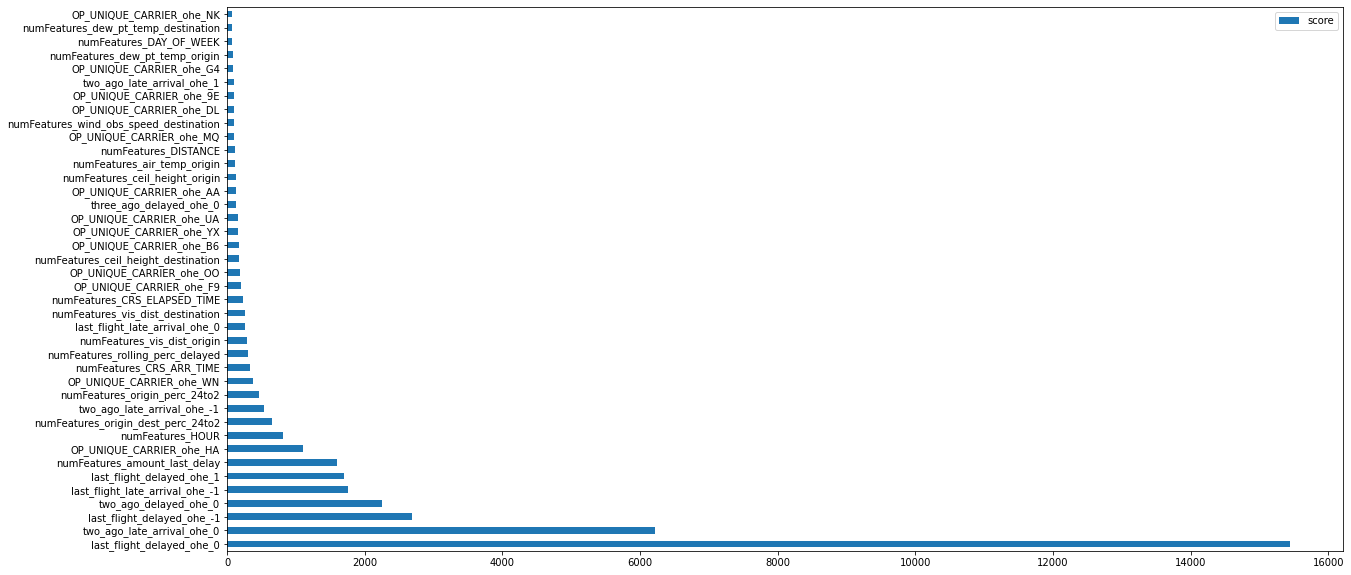

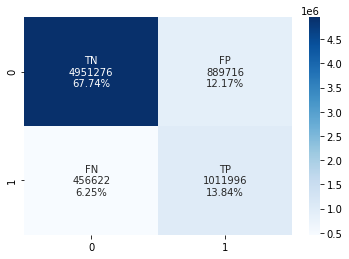

In [0]:
train_df = spark.read.parquet(f"{blob_url}/alt_pipeline_trainval")
# Select 2017 and 2018 as the training years and downsample
# We chose 2017 and 2018 since the Spark executor consistently crashed when we used >2yrs when training XGBoostClassifier and to allow time for some of our lagged features to become less volatile
train_df = train_df.filter((col('YEAR') == 2017) | (col('YEAR') == 2018)).cache()
test_df = spark.read.parquet(f"{blob_url}/alt_pipeline_test").cache()
final_preds = model_results(train_df, test_df)

In [0]:
def end2end(flights, stations, weather):
    """Call of the functions in our pipeline in order to produce an end-to-end output"""
    
    # Add the origin and destination weather stations to flights
    airlines_w_stations = add_airline_features(stations, flights)
    
    # Join the flights and weather tables
    airlines_w_weather = flights_weather_join(airlines_w_stations, weather)
    
    # Add the additional time-based and other features
    df_raw = dt_table(airlines_w_weather)
    
    # Pass the raw data through the tree pipeline and split into the training and test sets
    df = tree_pipeline(df_raw)
    train = df.filter((col('YEAR') == 2017) | (col('YEAR') == 2018))
    test = df.filter(col('YEAR') == 2019)
    
    # Get the model results
    output = model_results(train, test)
    
    return output

# Uncomment the following lines to run the pipeline end-to-end, otherwise, using the above code block to test the model output from our last check-point
# Load the flights, stations, and weather data
#flights, stations, weather = load_data()

# Otherwise, set your own flights, stations, and weather tables and pass them into end2end
#end2end(flights, stations, weather)

# Conclusions
As displayed in the confusion matrix above, approximately 18% of observations were misclassified, with 12% of misclassifications being false positives and the remaining 6% false negatives. The majority of true positives are correctly classified (approximately 69%), meeting our business objective, but this comes at the expense of a decline in precision - approximately 15% of flights that are not delayed 15+ minutes, cancelled, or diverted are misclassified as having one of these outcomes. While we believe that greater accuracy in correctly classifying true delays/diversions/cancellations is more important from a customer perspective than incorrectly predicting a flight as delayed/diverted/cancelled, additional work is needed to achieve a high recall score while minimizing false positive predictions.

From the results of our XGBoost Classifier, we also see that the model does not appear to have overfit on the training data. Accuracy is actually higher on the test set than on the training set, and recall on the test set is not far from that of the training set, indicating that there room to increase the complexity of model by adding additional features, altering hyperparameters, etc. 

Overall we believe that additional feature development/engineering can still signicantly improve the model. The time-based features that we engineered so far, are ranked by the model (see above) as by far the most important/useful in seperating the data. However, there is still a lot we can do. Below you can see how bad outcomes come in waves, as delays and cancellations lead to more delays and cancellations. In a few instances, however, our model is still predicting 0 because there is significant time from arrival until the next flight. What the model is not understanding is that given the prior string of cancellations the plane in question is simply not at the required airport, so it is easy to predict a 1. 

<img src="files/shared_uploads/bdougall@berkeley.edu/missed_predictions.png" width="800"/>

Overall developing the right features to allow the model to understand these chains of events is complex and requires careful thought and detailed analysis of where the model is making mistakes. We believe significant improvements could still be made with time. The same goes for the weather data features, which essentially were not used in our final model. Weather certainly has an impact on flight delays, so additional work must be needed to either bring in better weather features or else transform the existing ones. With additional time, we would focus on refining these features and believe performance can be significantly improved.

However, as of the time of writing, we can see on the leaderboard that we have the 3rd highest recall score (our priority metric), and the 3rd highest F1 score (indicating that our model is not too imbalanced). Our results relative to other groups suggest that we made a competitive model given the time limitations and learning curve involved.

In [0]:
#code for analyzing missed predictions for a specific tail number over time
xgb_testpreds = spark.read.parquet(f"{blob_url}/xgb_testpreds")
xgb_testpreds = xgb_testpreds.sort(col('TAIL_NUM'),col('utc_scheduled_departure').asc())
display(xgb_testpreds.select('TAIL_NUM','ORIGIN','DEST','utc_scheduled_departure','last_flight_delayed','amount_last_delay','arrival_time_2_next_flight','prediction','label').filter(col('TAIL_NUM')=='218NV').limit(10))

# Course Concepts

##### Parquet and UDFs for analytical processing
When performing our initial EDA and related analytical processing of the data, we made sure to take advantage of the benefits parquet files bring, and also to leverage spark UDFs for column transformations. 

Parquet's metadata and column oriented nature facilitates fast and efficient queries powered by the Pushdown Predicate. We took advantage of this by relying heavily on filter transformations, count transformations, etc., in order to analyze our data. All of these transformations ran quite quickly, even on the full dataset.

In addition, we wrote a number of UDF functions and applied them in a column based fashion, turning one or multiple collumns into new columns. These performed very well and generally had maximum run-time of just 1-2 minutes, even on the full dataset. 

#### Optimizing Joins for Distributed Computing
Throughout the 4 phases we performed numberous joins, first and foremost joining the weather data to the airlines (which was itself muliple joins), and also testing out a few additional features such as average passenger per route and average fair per route etc. 

One key principle we kept in mind was to always try to keep one of the datasets small, so that it could be broadcast to all the mapper nodes and held in memory. This results in a much faster join time vs joining two larger datasets, as the join can be completed fully within a single map phase without shuffling and sorting the two datasets.

Key instances where we took advantage of this included first filtering the stations dataset down to its unique stations before joining the ICAO call to each weather station.

##### Regression Models vs Tree Models
Understanding how these models work under the hood allowed us to clearly visualize how a tree model would likely outperform a regression model for the task at hand. While regression models are great for finding linear relationships between features and an outcome, tree models are better suited for non-linear problem spaces exemplified by chained IF statements or the classic XOR problem.

<img src="files/shared_uploads/bdougall@berkeley.edu/XOR.png" width="400"/>

For the problem at hand, and particularly for modeling many of our time-based features, the correct outcome can clearly be visualized as a chain of IF statements. For example IF the plane is delayed at its prior departure, and IF the delay is over x minutes, and IF the plane is expected to turnaround within x minutes at its next airport, etc.

When engineering our features we did our best to think about how a decision tree would evaluate the features at each node to find the best seperation.

##### Pipelines
Pipelines are used to combine complex algorithms and transformations to create a workflow. Depending on the selected features, the pipeline can take several steps, including indexing categorical features, endcode to one hot vectors, normalize the scale and assemble to a feature vector. We built a pipeline function combing several of these, allowing for efficient cycling between feature engineering to update the dataset, the pipeline to prepare the data for modeling,and modeling to test our performance.

# Reference

1. https://www.faa.gov/data_research/aviation_data_statistics/media/cost_delay_estimates.pdf
2. https://www.eurocontrol.int/sites/default/files/library/022_Flight_Delay_Propagation.pdf
3. https://arxiv.org/abs/1903.06740
4. https://journalofbigdata.springeropen.com/articles/10.1186/s40537-020-00380-z
5. Hastie, Trevor, Tibshirani, Robert, Witten, Daniela, & James, Gareth. (2014). An Introduction to Statistical Learning: with Applications in R. Stanford, CA: Springer Publishing Company. Page 338.
6. Karau, Warren. (2017). High Performance Spark: Best Practices for Scaling and Optimizing Apache Spark. Sebastopol, CA: O’Reilly Publishers.
7. http://www.svds.com/dataformats/